In [3]:
# needed imports
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import pandas as pd

In [4]:
'''
First define a function to read in fasta file.
1. adding line = line.rstrip(), which will remove \n at the end of each line
2. save results as a generator object, with name (strains) and seq (genomes), easier to store and reference

'''
import pandas as pd
import numpy as np

def read_fasta(fp):
        name, seq = None, []
        for line in fp:
            line = line.rstrip()
            if line.startswith(">"):
                if name: yield (name, ''.join(seq))
                name, seq = line, []
            else:
                seq.append(line)
        if name: yield (name, ''.join(seq))

            

In [5]:
#adding strain data to one array and genomic data to the other
strains = []
genomes = []

with open(r'C:/Users/srava/BedfordProjects/zika/results/aligned.fasta') as fp:
    for name, seq in read_fasta(fp):
            strains.append(name)
            genomes.append(seq)

In [6]:
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [7]:
# Return the Hamming distance between string1 and string2.
# string1 and string2 should be the same length.
def hamming_distance(array1, array2): 
    # Start with a distance of zero, and count up
    distance = 0
    # Loop over the indices of the string
    L = len(array1)
    for i in range(L):
        # Add 1 to the distance if these two characters are not equal
        if array1[i] != array2[i] and array1[i] != 'N' and array2[i] != 'N':
            distance += 1
    # Return the final count of differences
    return distance

In [8]:
#This does not work yet, but it for optimizing hamming distance algortihm. Will convert dataa to csv soon
def hamming_distance2(array1, array2):
    array1 = np.array(list(array1))
    array2 = np.array(list(array2))
    return (array1 != array2).sum()

In [9]:
#Using the Hamming distance to create a similarity matrix
numbers = []
matrixOfNum = []
for i in range(0,len(genomes)):
    for j in range(0,len(genomes)):
        num = hamming_distance(genomes[i],genomes[j])
        numbers.append(num)
    matrixOfNum.append(numbers)
    numbers = []
dataa = pd.DataFrame(matrixOfNum, columns = ["strain " + str(i) for i in range(1,len(matrixOfNum) + 1)], dtype="float")
print(dataa)

     strain 1  strain 2  strain 3  strain 4  strain 5  strain 6  strain 7  \
0         0.0      12.0      15.0      14.0      19.0      13.0      12.0   
1        12.0       0.0      15.0      14.0      18.0      13.0      11.0   
2        15.0      15.0       0.0      17.0      21.0      16.0      14.0   
3        14.0      14.0      17.0       0.0       8.0      15.0      13.0   
4        19.0      18.0      21.0       8.0       0.0      20.0      19.0   
5        13.0      13.0      16.0      15.0      20.0       0.0      13.0   
6        12.0      11.0      14.0      13.0      19.0      13.0       0.0   
7        13.0      12.0      15.0      12.0      18.0      14.0      13.0   
8        13.0      12.0      15.0      14.0      20.0      14.0      13.0   
9        18.0      19.0      22.0      21.0      27.0      21.0      19.0   
10       18.0      19.0      22.0      21.0      27.0      21.0      19.0   
11       15.0      15.0      16.0      16.0      20.0      16.0      14.0   

AxesSubplot(0.125,0.125;0.62x0.755)


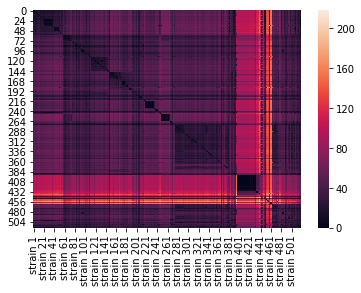

In [12]:
import seaborn as sns
print(sns.heatmap(dataa))
#This is to check my data still looks like a similarity matrix (makes sure the data is correctly parsed)

In [13]:
#Generate condensed matrix for use with linkage call (or to create the clusters). Condensed matrix is one of the forms you can pass
#(There are multiple, but this is easiest for using a distance matrix).
matrix_size = len(matrixOfNum)
matrix_of_num = np.array(matrixOfNum)

#get indicies of upper triangle of matrix
iu = np.triu_indices(matrix_size,1)
matrix_ut = matrix_of_num[iu]
Z = linkage(matrix_ut, 'ward')

In [14]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(matrix_of_num))
#c gives you a measure of cleanly you can divide the data into clusters. 1.0 means you can perfectly divide them. For zika, the number is in the upper 70s, so it's not hard to cluster the data. 
#With recombinant viruses/bacteria, this number will probably be lower. The C function is built into scipy.
print(c)


0.7731577466854826


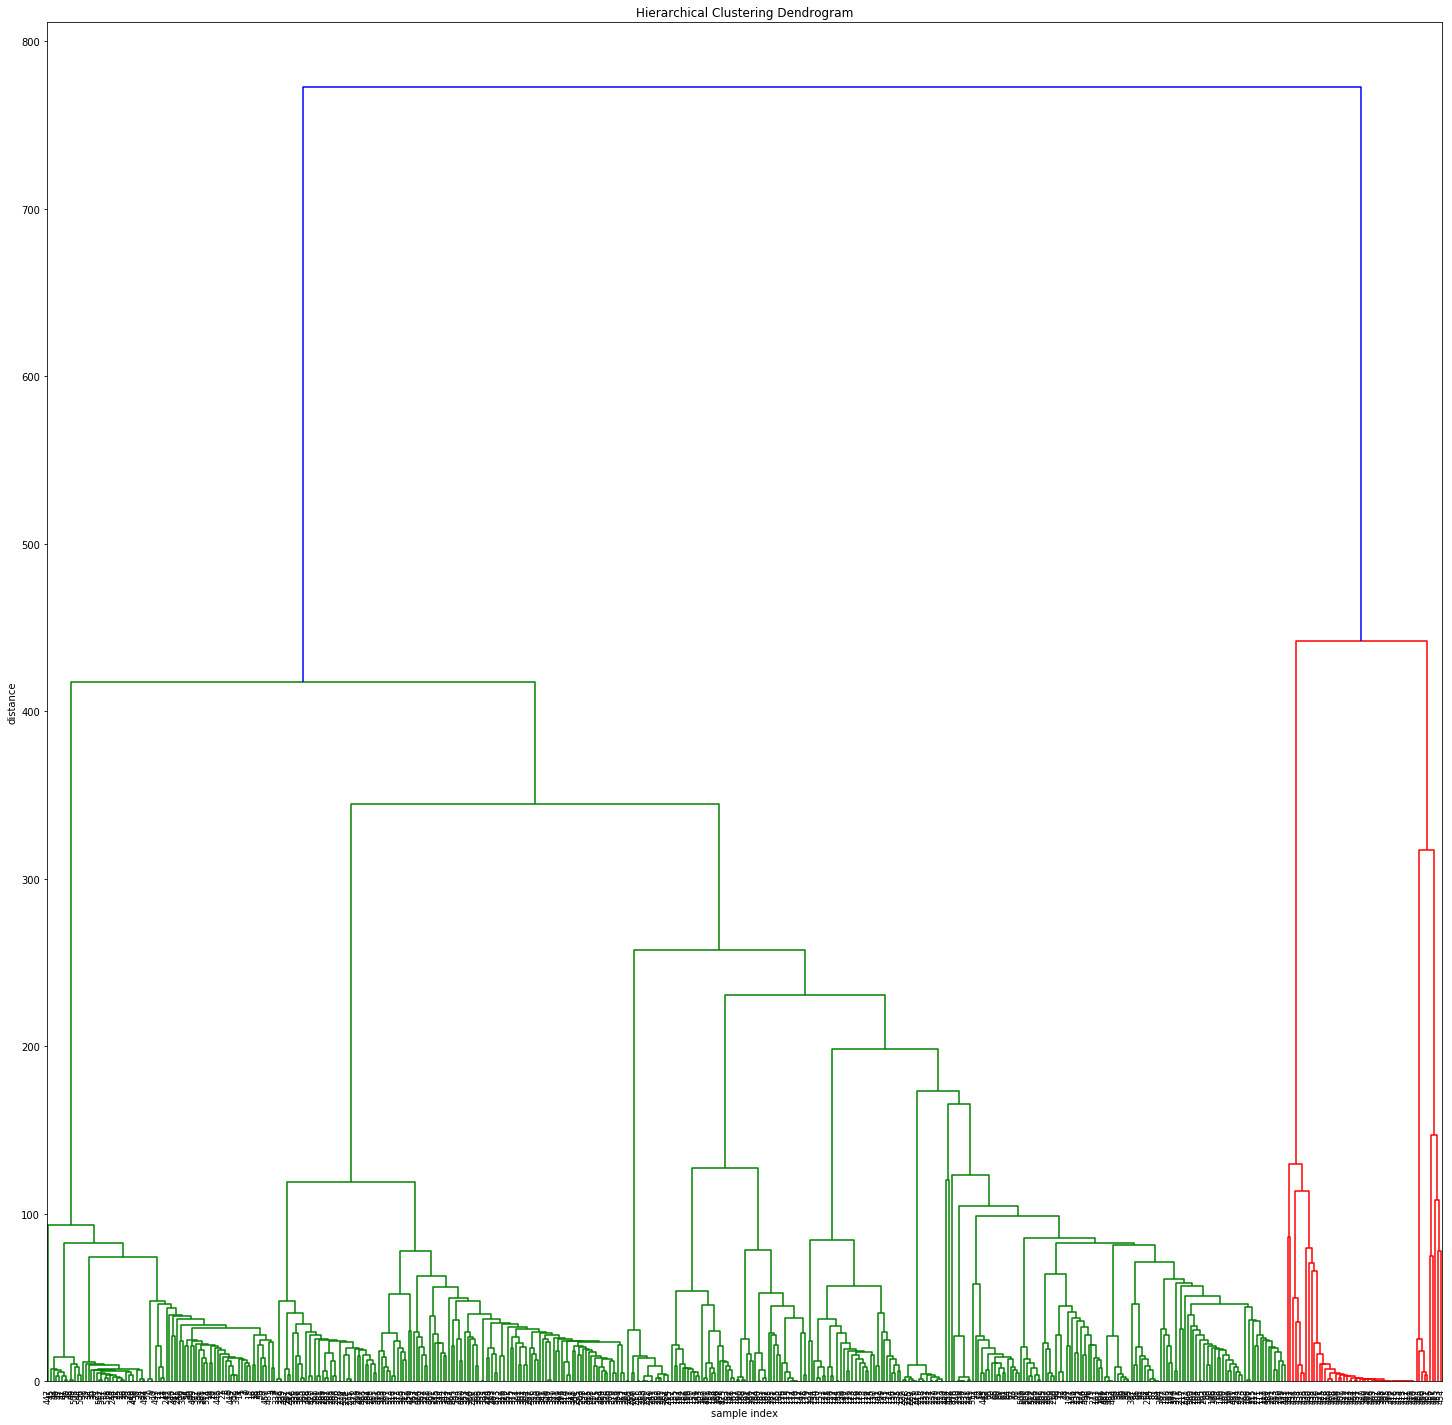

In [15]:
#Here we plot the dendrogram of the 519 strains
# calculate full dendrogram
plt.figure(figsize=(25, 25))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index') #they are hard to read, so the other dendogram is probably more helpful
plt.ylabel('distance') #distance being hamming distance
dendrogram( #this is built into sci py
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

45


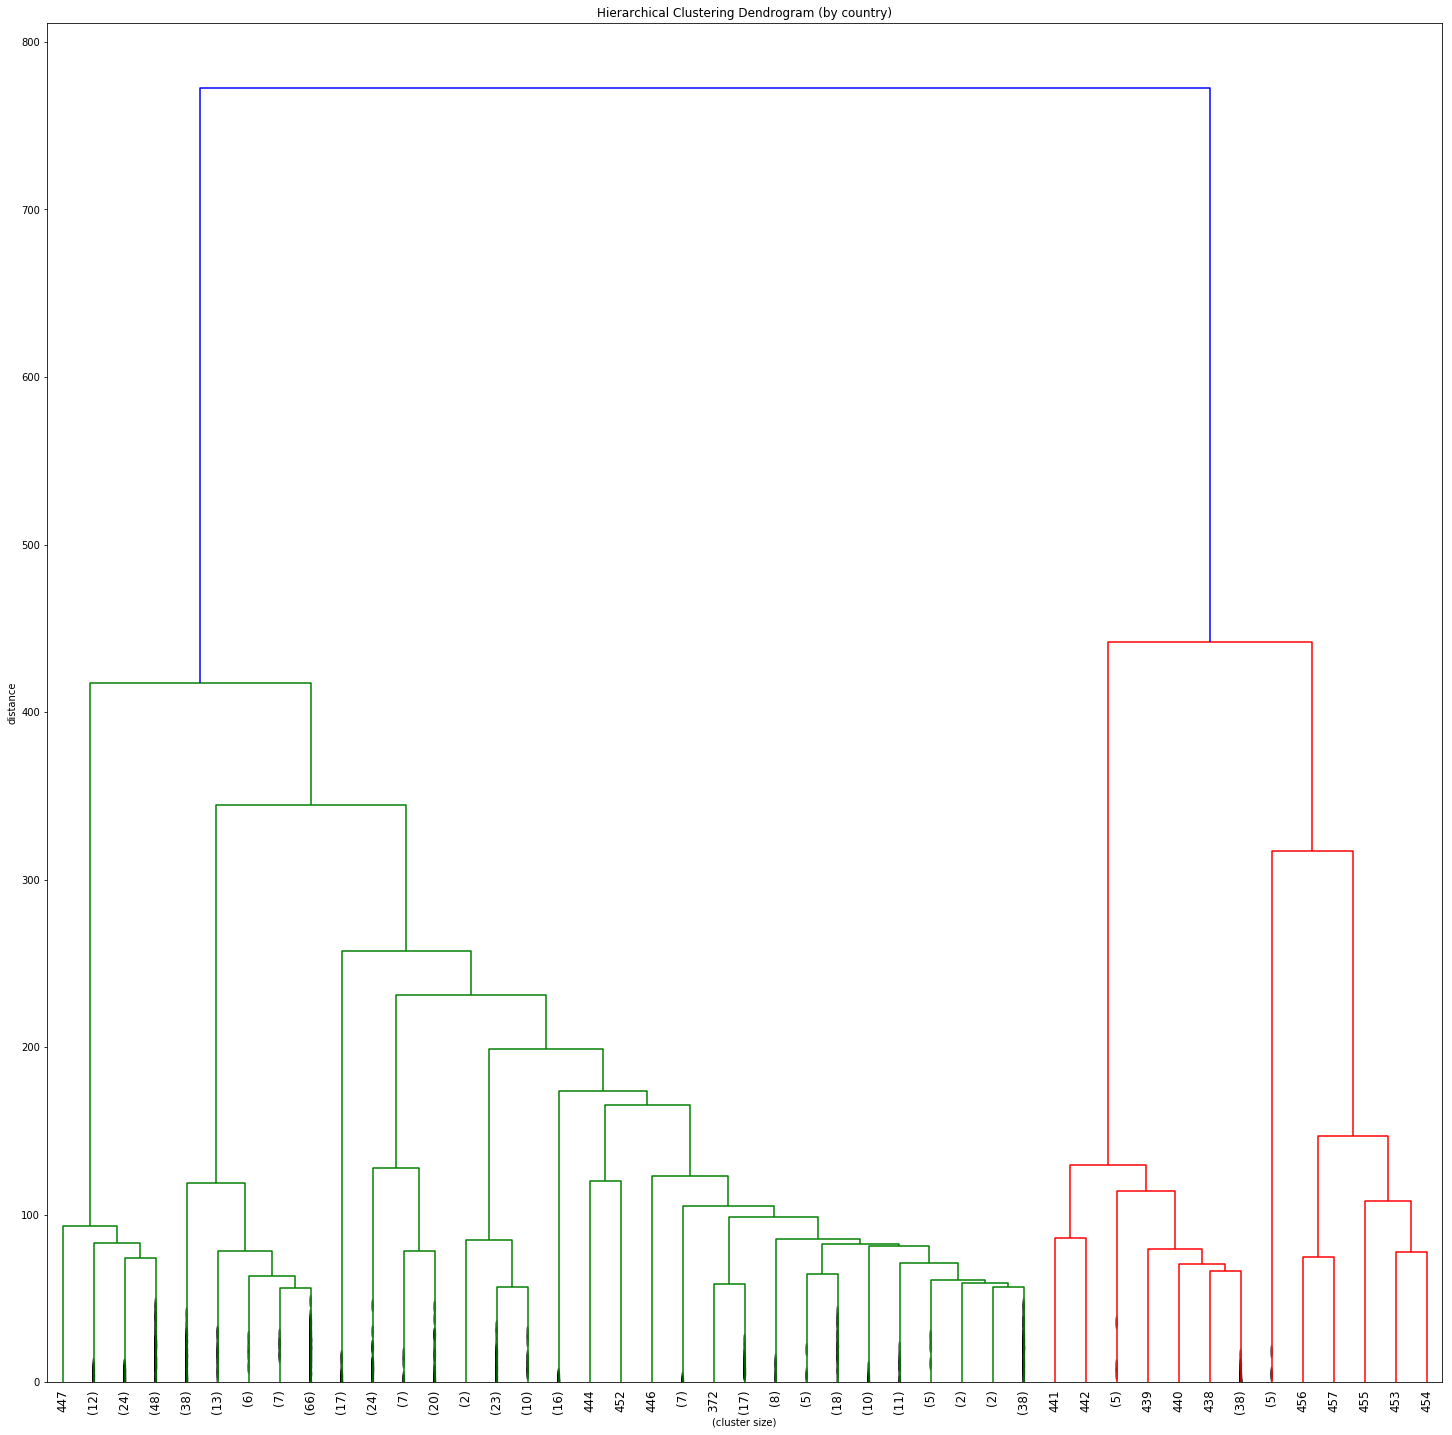

In [16]:
#Here I plot the dendogram assuming there are 45 clusters corresponding to each country. It "clumps" the countries that fit on a cluster together
#I assume all strains originating from a country will be similar -- using the dendogram will allow the user to see how "pure" or "impure" the country based cluster is.
#we could easily do this for region if you think thats useful
metadata_df = pd.read_csv(r'C:\Users\srava\BedfordProjects\zika\results\metadata.tsv', delimiter='\t',encoding='utf-8')
country_df = metadata_df[['country','strain']]
countries = set(metadata_df['country'].values)
print(len(countries))

plt.figure(figsize=(25, 25))
plt.title('Hierarchical Clustering Dendrogram (by country)')
plt.xlabel('(cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=len(countries),  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [17]:
#This allows me to see which strains were put into what clusters. 
#It allows allows me to see which countries have more similar strain circulating versus places where the strains are very dissimilar.
from scipy.cluster.hierarchy import fcluster
cluster_indices = fcluster(Z, len(countries), criterion='maxclust')

#add the cluster index to the strain dataframe
dataa["cluster_index"] = cluster_indices
dataa["strain_index"] = list(range(len(matrixOfNum)))
#check if the counts line up with dendogram and they do!
#Build list of lists of 45 clusters
cluster_ids = set(cluster_indices) #cluster ids is now a list of the cluster indices
result = []
for i in cluster_ids:
    lst = list(dataa[dataa.cluster_index == i]['strain_index'].values)#looking for where the indexes of the cluster are the same as the cluster index of the strain
    print("Cluster: {}, Strains: {}, Number: {}".format(i,lst, len(lst)))#prints out the cluster name, and strains, and how many strains are in that cluster
result


Cluster: 1, Strains: [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 506, 508], Number: 12
Cluster: 2, Strains: [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 244, 248, 458, 494, 502, 517, 518], Number: 24
Cluster: 3, Strains: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 39, 40, 51, 52, 53, 54, 55, 56, 57, 58, 245, 246, 247, 381, 382, 388, 389, 390, 448, 449, 450, 481, 487, 493, 499, 514], Number: 48
Cluster: 4, Strains: [447], Number: 1
Cluster: 5, Strains: [275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 334, 335, 336, 337, 338, 339, 355, 356, 360, 361, 365, 378, 468, 469, 470, 471, 492, 497, 507, 511], Number: 38
Cluster: 6, Strains: [307, 308, 309, 312, 313, 315, 316, 317, 359, 373, 479, 496, 513], Number: 13
Cluster: 7, Strains: [327, 328, 362, 363, 466, 474], Number: 6
Cluster: 8, Strains: [342, 343, 344, 345, 391, 486, 510], Number: 7
Cluster: 9, Strains: [293, 294, 295, 296, 297, 298, 299

[]

In [18]:
principalDf = pd.DataFrame(Z)

In [19]:
#merging my final dataframe with their regions and strain names
import pandas as pd
metadata_df = pd.read_csv(r'C:\Users\srava\BedfordProjects\zika\results\metadata.tsv', delimiter='\t',encoding='utf-8')
country_df = metadata_df[['country','strain']]
 
strains_df = pd.DataFrame(strains)
strains_df.columns = ['strain']


colors_df = pd.read_csv(r'C:\Users\srava\BedfordProjects\zika\config\colors.tsv', delimiter='\t',encoding='utf-8')
colors_df.columns = ['y','country', 'color']
colors_df1 = colors_df[['country','color']]

result = pd.merge(metadata_df,
                 colors_df1[['country', 'color']],
                 on='country')
result_df_region = result[['strain','region']]
result_df = result[['region', 'strain','country','color']]

finalDf = pd.concat([principalDf, result_df[['region','country','strain']]], axis = 1)
finalDf.columns = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4','region', 'country', 'strain']

In [20]:
finalDf

,cluster 1,cluster 2,cluster 3,cluster 4,region,country,strain
0,248.0,458.0,0.0,2.0,oceania,french_polynesia,1_0015_PF
1,22.0,25.0,0.0,2.0,oceania,french_polynesia,1_0016_PF
2,32.0,494.0,0.0,2.0,oceania,french_polynesia,1_0030_PF
3,83.0,84.0,0.0,2.0,oceania,french_polynesia,1_0035_PF
4,87.0,522.0,0.0,3.0,oceania,french_polynesia,1_0038_PF
5,9.0,10.0,0.0,2.0,oceania,french_polynesia,1_0049_PF
6,483.0,484.0,0.0,2.0,oceania,french_polynesia,1_0080_PF
7,485.0,525.0,0.0,3.0,oceania,french_polynesia,1_0087_PF
8,170.0,172.0,0.0,2.0,oceania,french_polynesia,1_0111_PF
9,104.0,105.0,0.0,2.0,oceania,french_polynesia,1_0117_PF


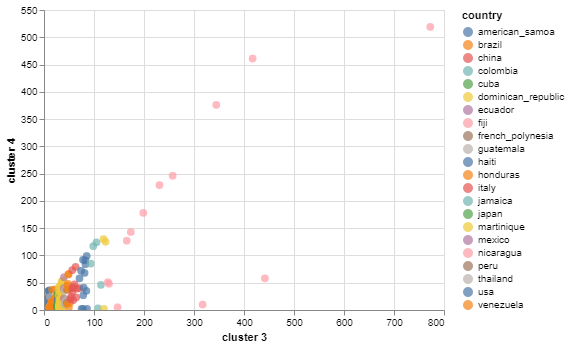

In [21]:
import altair as alt

alt.Chart(finalDf).mark_circle(size=60).encode(
    x='cluster 3',
    y='cluster 4',
    color='country',
    tooltip=['strain', 'country']
).interactive()
#Make this into a website (view compiled vega -- gives you the javascript -- put that into a HTML script)

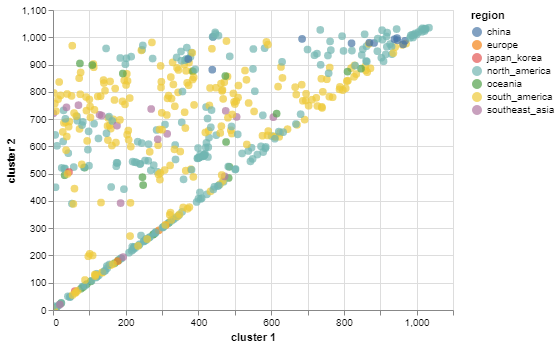

In [22]:
import altair as alt
#read these cluster ACROSS (horizontallu) -- im pretty sure cluster 3 and cluster 4 are more useful to see clustering
alt.Chart(finalDf).mark_circle(size=60).encode(
    x='cluster 1',
    y='cluster 2',
    color='region',
    tooltip=['strain', 'country']
).interactive()
#Make this into a website (view compiled vega -- gives you the javascript -- put that into a HTML script)

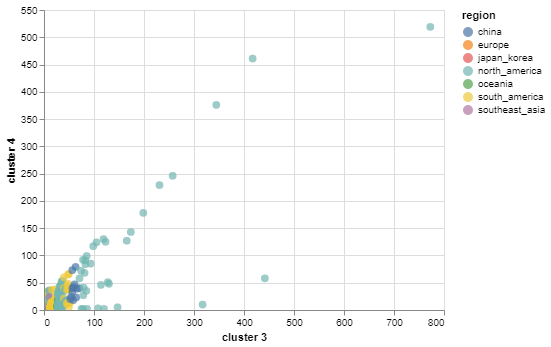

In [23]:
import altair as alt

alt.Chart(finalDf).mark_circle(size=60).encode(
    x='cluster 3',
    y='cluster 4',
    color='region',
    tooltip=['strain', 'region']
).interactive()
#Make this into a website (view compiled vega -- gives you the javascript -- put that into a HTML script)

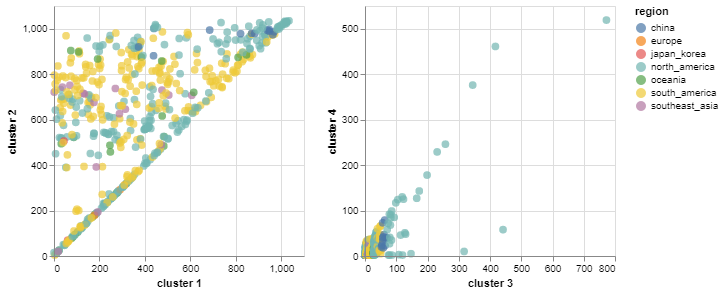

In [24]:
import altair as alt


brush = alt.selection(type='interval', resolve='global')
#link the charts
pc1 = alt.Chart(finalDf).mark_circle(size=60).encode(
    x='cluster 1',
    y='cluster 2',
    color=alt.condition(brush, 'region', alt.ColorValue('gray')),
    tooltip=['strain', 'region']
).add_selection(
    brush
).properties(
    width=250,
    height=250
)
#Make this into a website (view compiled vega -- gives you the javascript -- put that into a HTML script)

pc34 = alt.Chart(finalDf).mark_circle(size=60).encode(
    x='cluster 3',
    y='cluster 4',
    color=alt.condition(brush, 'region', alt.ColorValue('gray')),
    tooltip=['strain', 'region']
).add_selection(
    brush
).properties(
    width=250,
    height=250
)

   
pc1.encode(x='cluster 1') | pc34.encode(x='cluster 3')